In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pyspark.sql.functions as F
import sys 
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
spark = SparkSession.builder \
    .master("spark://10.129.6.139:7077") \
    .appName("Visualization") \
    .getOrCreate()

In [3]:
df = spark.read.csv("/mnt/bdpa21-group9-pvc/Data/Traffic_Violations_preprocessed.csv", header=True, inferSchema=True)

In [4]:
df.printSchema()

root
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Belts: integer (nullable = true)
 |-- Personal Injury: integer (nullable = true)
 |-- Property Damage: integer (nullable = true)
 |-- Fatal: integer (nullable = true)
 |-- HAZMAT: integer (nullable = true)
 |-- Commercial Vehicle: integer (nullable = true)
 |-- Alcohol: integer (nullable = true)
 |-- Work Zone: integer (nullable = true)
 |-- VehicleType: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Color: string (nullable = true)
 |-- Violation Type: string (nullable = true)
 |-- Contributed To Accident: integer (nullable = true)
 |-- Race: string (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Datetime: timestamp (nullable = true)



In [5]:
df.show(2, vertical=True)

-RECORD 0--------------------------------------
 Latitude                | NaN                 
 Longitude               | NaN                 
 Belts                   | 0                   
 Personal Injury         | 0                   
 Property Damage         | 0                   
 Fatal                   | 0                   
 HAZMAT                  | 0                   
 Commercial Vehicle      | 0                   
 Alcohol                 | 0                   
 Work Zone               | 0                   
 VehicleType             | Automobile          
 Year                    | 2008.0              
 Color                   | BLACK               
 Violation Type          | Citation            
 Contributed To Accident | 0                   
 Race                    | BLACK               
 Gender                  | 1                   
 Datetime                | 2013-09-24 17:11:00 
-RECORD 1--------------------------------------
 Latitude                | 38.983578    

In [115]:
dfr = df.groupby("Race").count()
total = dfr.agg(F.sum("count")).first()[0]
dfr.withColumn("%", F.round(F.col("count") / total * 100, 2)).show()

+---------------+------+-----+
|           Race| count|    %|
+---------------+------+-----+
|          WHITE|376286|36.94|
|          BLACK|317298|31.15|
|       HISPANIC|210534|20.67|
|NATIVE AMERICAN|  2434| 0.24|
|          OTHER| 52516| 5.16|
|          ASIAN| 59566| 5.85|
+---------------+------+-----+



## Part 1: How does the time of the day affect the seriousness of a violation?

In [6]:
binvars = ['Belts',
 'Personal Injury',
 'Property Damage',
 'Fatal',
 'HAZMAT',
 'Commercial Vehicle',
 'Alcohol',
 'Work Zone',
 'Contributed To Accident',
 'Gender']
for c in binvars:
    temp = df.groupby(F.hour("Datetime").alias("Hour of a Day")).agg(F.count("*").alias("N of violations"), F.sum(c).alias(c)).sort("Hour of a Day")
    temp.withColumn("Percent (%)", F.round(F.col(c) / F.col("N of violations")*100, 2)).show(24)

+-------------+---------------+-----+-----------+
|Hour of a Day|N of violations|Belts|Percent (%)|
+-------------+---------------+-----+-----------+
|            0|          55611|  992|       1.78|
|            1|          44856|  790|       1.76|
|            2|          34323|  665|       1.94|
|            3|          22633|  486|       2.15|
|            4|          13936|  352|       2.53|
|            5|           9412|  375|       3.98|
|            6|          15148|  748|       4.94|
|            7|          36511| 1845|       5.05|
|            8|          55848| 2902|        5.2|
|            9|          51310| 2530|       4.93|
|           10|          52041| 2868|       5.51|
|           11|          44005| 2726|       6.19|
|           12|          40768| 2057|       5.05|
|           13|          41352| 1966|       4.75|
|           14|          42971| 1986|       4.62|
|           15|          36142| 1700|        4.7|
|           16|          48434| 1733|       3.58|


+-------------+---------------+-------+-----------+
|Hour of a Day|N of violations|Alcohol|Percent (%)|
+-------------+---------------+-------+-----------+
|            0|          55611|     57|        0.1|
|            1|          44856|     15|       0.03|
|            2|          34323|     41|       0.12|
|            3|          22633|     68|        0.3|
|            4|          13936|     28|        0.2|
|            5|           9412|     16|       0.17|
|            6|          15148|     52|       0.34|
|            7|          36511|    124|       0.34|
|            8|          55848|    142|       0.25|
|            9|          51310|    135|       0.26|
|           10|          52041|     66|       0.13|
|           11|          44005|     30|       0.07|
|           12|          40768|     46|       0.11|
|           13|          41352|     87|       0.21|
|           14|          42971|     78|       0.18|
|           15|          36142|    136|       0.38|
|           

In [24]:
temp = df.groupby(F.hour("Datetime").alias("Hour of a Day")).agg(
    F.count("*").alias("N of violations"), 
    F.sum('Personal Injury').alias('Personal Injury'),
    F.sum('Property Damage').alias('Property Damage'),
    F.sum('Fatal').alias('Fatal'),
    F.sum('Contributed To Accident').alias('Contributed To Accident')
).sort("Hour of a Day")
temp = temp.withColumn("Personal Injury Percent (%)", F.round(F.col('Personal Injury') / F.col("N of violations")*100, 2)).withColumn("Property Damage Percent (%)", F.round(F.col('Property Damage') / F.col("N of violations")*100, 2)).withColumn("Fatal Percent (%)", F.round(F.col('Fatal') / F.col("N of violations")*100, 2)).withColumn("Contributed To Accident Percent (%)", F.round(F.col('Contributed To Accident') / F.col("N of violations")*100, 2))

In [25]:
temppd = temp.toPandas()

In [26]:
temppd

,Hour of a Day,N of violations,Personal Injury,Property Damage,Fatal,Contributed To Accident,Personal Injury Percent (%),Property Damage Percent (%),Fatal Percent (%),Contributed To Accident Percent (%)
0,0,55611,378,945,10,926,0.68,1.70,0.02,1.67
1,1,44856,297,968,5,746,0.66,2.16,0.01,1.66
2,2,34323,361,771,2,697,1.05,2.25,0.01,2.03
3,3,22633,242,769,1,770,1.07,3.40,0.00,3.40
4,4,13936,243,524,10,558,1.74,3.76,0.07,4.00
5,5,9412,249,418,4,445,2.65,4.44,0.04,4.73
6,6,15148,371,337,11,605,2.45,2.22,0.07,3.99
7,7,36511,548,630,13,969,1.50,1.73,0.04,2.65
8,8,55848,704,825,4,1209,1.26,1.48,0.01,2.16
9,9,51310,553,728,6,1048,1.08,1.42,0.01,2.04


In [89]:
#from pyspark.ml.feature import Bucketizer
#
#temp2 = df.withColumn("Hour", F.hour("Datetime"))
#
#bucketizer = Bucketizer(
#    splits=[0,3,6,9,12,15,18,21,24], inputCol="Hour", outputCol="Time"
#)
#
#temp2 = bucketizer.transform(temp2)
#
#temp2 = temp2.groupby("Time").agg(
#    F.count("*").alias("N of violations"), 
#    F.sum('Personal Injury').alias('Personal Injury'),
#    F.sum('Property Damage').alias('Property Damage'),
#    F.sum('Fatal').alias('Fatal')
#).sort("Time")
#temp2 = temp2.withColumn("Personal Injury Percent (%)", F.round(F.col('Personal Injury') / F.col("N of violations")*100, 2)).withColumn("Property Damage Percent (%)", F.round(F.col('Property Damage') / F.col("N of violations")*100, 2)).withColumn("Fatal Percent (%)", F.round(F.col('Fatal') / F.col("N of violations")*100, 2))

Text(0.5, 1.0, '')

Text(0.5, 0, 'Time of day')

[Text(0, 0, '0'),
 Text(0, 0, '3'),
 Text(0, 0, '6'),
 Text(0, 0, '9'),
 Text(0, 0, '12'),
 Text(0, 0, '15'),
 Text(0, 0, '18')]

Text(0, 0.5, 'Percentage of violations (%)')

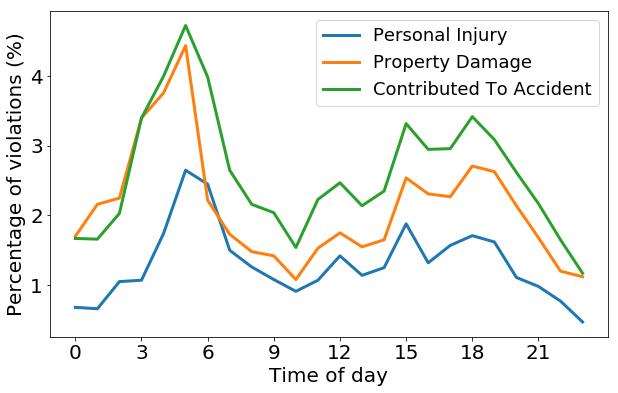

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot('Hour of a Day', 'Personal Injury Percent (%)', data=temppd, linewidth=3, label='Personal Injury')
ax.plot('Hour of a Day', 'Property Damage Percent (%)', data=temppd, linewidth=3, label='Property Damage')   
ax.plot('Hour of a Day', 'Contributed To Accident Percent (%)', data=temppd, linewidth=3, label='Contributed To Accident') 
ax.set_title('')
ax.set_xlabel('Time of day', size=20)
ax.set_xticklabels([0,3,6,9,12,15,18,21], fontsize=20)
ax.set_xticks([0,3,6,9,12,15,18,21])
ax.set_ylabel('Percentage of violations (%)', size=20)
ax.tick_params(axis='y', labelsize=20) 
ax.legend(fontsize=18)



In [28]:
fig.savefig("/mnt/bdpa21-group9-pvc/Figures/seriousness_vs_time.png")

## Part 2: Were seat belts in use or was there alcohol involved in deffirent types of serious violations?

In [17]:
df.where(F.col("Personal Injury") == 1).groupby("Alcohol").count().show()
df.where(F.col("Property Damage") == 1).groupby("Alcohol").count().show()
df.where(F.col("Fatal") == 1).groupby("Alcohol").count().show()
df.where(F.col("Contributed To Accident") == 1).groupby("Alcohol").count().show()

df.where(F.col("Personal Injury") == 1).groupby("Belts").count().show()
df.where(F.col("Property Damage") == 1).groupby("Belts").count().show()
df.where(F.col("Fatal") == 1).groupby("Belts").count().show()
df.where(F.col("Contributed To Accident") == 1).groupby("Belts").count().show()

+-------+-----+
|Alcohol|count|
+-------+-----+
|      1|   72|
|      0|11702|
+-------+-----+

+-------+-----+
|Alcohol|count|
+-------+-----+
|      1|  127|
|      0|18829|
+-------+-----+

+-------+-----+
|Alcohol|count|
+-------+-----+
|      0|  213|
+-------+-----+

+-------+-----+
|Alcohol|count|
+-------+-----+
|      1|  116|
|      0|23515|
+-------+-----+

+-----+-----+
|Belts|count|
+-----+-----+
|    1| 2495|
|    0| 9279|
+-----+-----+

+-----+-----+
|Belts|count|
+-----+-----+
|    1| 2594|
|    0|16362|
+-----+-----+

+-----+-----+
|Belts|count|
+-----+-----+
|    1|    6|
|    0|  207|
+-----+-----+

+-----+-----+
|Belts|count|
+-----+-----+
|    1| 2800|
|    0|20831|
+-----+-----+



In [18]:
df.where(F.col("Personal Injury") == 1).agg(F.round(F.avg("Alcohol")*100,2)).show()
df.where(F.col("Property Damage") == 1).agg(F.round(F.avg("Alcohol")*100,2)).show()
df.where(F.col("Fatal") == 1).agg(F.round(F.avg("Alcohol")*100,2)).show()
df.where(F.col("Contributed To Accident") == 1).agg(F.round(F.avg("Alcohol")*100,2)).show()

df.where(F.col("Personal Injury") == 1).agg(F.round(F.avg("Belts")*100,2)).show()
df.where(F.col("Property Damage") == 1).agg(F.round(F.avg("Belts")*100,2)).show()
df.where(F.col("Fatal") == 1).agg(F.round(F.avg("Belts")*100,2)).show()
df.where(F.col("Contributed To Accident") == 1).agg(F.round(F.avg("Belts")*100,2)).show()

+------------------------------+
|round((avg(Alcohol) * 100), 2)|
+------------------------------+
|                          0.61|
+------------------------------+

+------------------------------+
|round((avg(Alcohol) * 100), 2)|
+------------------------------+
|                          0.67|
+------------------------------+

+------------------------------+
|round((avg(Alcohol) * 100), 2)|
+------------------------------+
|                           0.0|
+------------------------------+

+------------------------------+
|round((avg(Alcohol) * 100), 2)|
+------------------------------+
|                          0.49|
+------------------------------+

+----------------------------+
|round((avg(Belts) * 100), 2)|
+----------------------------+
|                       21.19|
+----------------------------+

+----------------------------+
|round((avg(Belts) * 100), 2)|
+----------------------------+
|                       13.68|
+----------------------------+

+-----------------------

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

<BarContainer object of 2 artists>

Text(0, 0.5, 'Percentage (%)')

Text(0.5, 1.0, '')

[Text(0, 0, 'Seat belt was in use'), Text(0, 0, 'Involved alcohol')]

Text(-0.36, 19.19, '21.19')

Text(1.1400000000000001, 0.61, '0.61')

Text(-0.12, 11.68, '13.68')

Text(1.38, 0.67, '0.67')

Text(0.12, 9.85, '11.85')

Text(1.62, 0.49, '0.49')

Text(0.36, 0.8199999999999998, '2.82')

Text(1.8599999999999999, 0.0, '0.0')

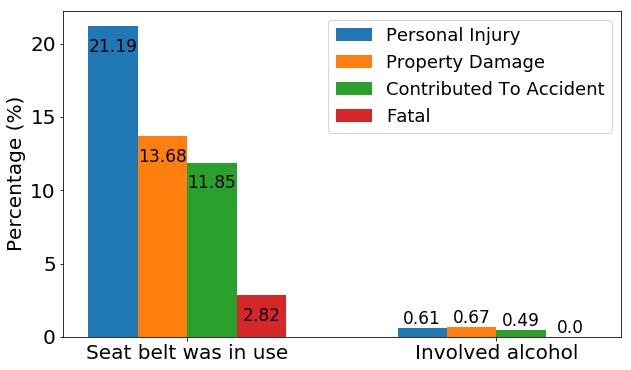

In [22]:
import numpy as np
labels = ['Seat belt was in use', 'Involved alcohol']
pinj = [21.19,0.61]
pdam = [13.68,0.67]
contr = [11.85, 0.49]
fatal = [2.82, 0.0]

x = np.arange(len(labels))*1.5  # label locations
width = 0.24

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(x - 1.5*width, pinj, width, label='Personal Injury')
ax.bar(x - 0.5*width, pdam, width, label='Property Damage')
ax.bar(x + 0.5*width, contr, width, label='Contributed To Accident')
ax.bar(x + 1.5*width, fatal, width, label='Fatal')
ax.set_ylabel('Percentage (%)', size=20)
ax.tick_params(axis='y', labelsize=20) 
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=20)
ax.legend(fontsize=18)

rects = ax.patches
labels = ["21.19", "0.61", "13.68", "0.67", "11.85", "0.49", "2.82", "0.0"]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    if float(label) < 1:
        ax.text(rect.get_x() + rect.get_width() / 2, height, label,
            ha='center', va='bottom', fontsize=17)
    else:
        ax.text(rect.get_x() + rect.get_width() / 2, height - 2, label,
            ha='center', va='bottom', fontsize=17)

In [23]:
fig.savefig("/mnt/bdpa21-group9-pvc/Figures/belts_or_alcohol_used_v2.png")

## Part 3: What is the gender distribution inside each type of serious violations?

In [4]:
dfg = df.where(F.col("Gender").isNotNull())

t = dfg.where(F.col("Personal Injury") == 1).groupby("Gender").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).show()

t = dfg.where(F.col("Property Damage") == 1).groupby("Gender").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).show()

t = dfg.where(F.col("Fatal") == 1).groupby("Gender").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).show()

t = dfg.where(F.col("Contributed To Accident") == 1).groupby("Gender").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).show()

+------+-----+----+
|Gender|count|   %|
+------+-----+----+
|     1| 7969|67.7|
|     0| 3802|32.3|
+------+-----+----+

+------+-----+-----+
|Gender|count|    %|
+------+-----+-----+
|     1|13204|69.67|
|     0| 5747|30.33|
+------+-----+-----+

+------+-----+-----+
|Gender|count|    %|
+------+-----+-----+
|     1|  126|59.15|
|     0|   87|40.85|
+------+-----+-----+

+------+-----+-----+
|Gender|count|    %|
+------+-----+-----+
|     1|15935|67.47|
|     0| 7683|32.53|
+------+-----+-----+



Text(0, 0.5, 'Percentage (%)')

Text(-0.1, 30, '67.7')

Text(-0.1, 80, '32.3')

Text(0.9, 30, '69.67')

Text(0.9, 80, '30.33')

Text(1.9, 30, '59.15')

Text(1.9, 80, '40.85')

Text(2.9, 30, '67.47')

Text(2.9, 80, '32.53')

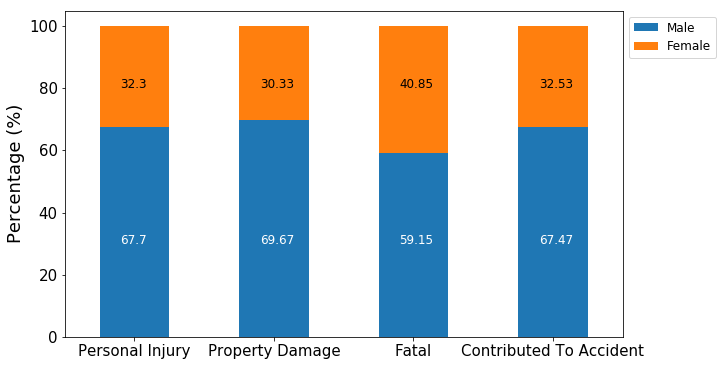

In [113]:
x_axis = ["Personal Injury", "Property Damage", "Fatal", "Contributed To Accident"]

index = pd.Index(x_axis)

data = {'Male': [67.7, 69.67, 59.15, 67.47],
        'Female': [32.3, 30.33, 40.85, 32.53]}

plot_data = pd.DataFrame(data, index=index)
ax = plot_data.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Percentage (%)', size=18)
ax.tick_params(axis='y', labelsize=15) 
ax.tick_params(axis='x', labelsize=15, rotation=0) 
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', fontsize=12)

for idx, label in enumerate(list(index)): 
    for acc in plot_data.columns:
        value = plot_data.iloc[idx][acc]
        if acc == "Male":
            ax.annotate(value, (idx - 0.1, 30), color="white", fontsize=12)
        else:
            ax.annotate(value, (idx - 0.1, 80), fontsize=12)
plt.savefig("/mnt/bdpa21-group9-pvc/Figures/gender_vs_seriousness.png")
plt.show()

## Part 4: Race distribution?

In [114]:
t = df.where(F.col("Personal Injury") == 1).groupby("Race").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).show()

t = df.where(F.col("Property Damage") == 1).groupby("Race").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).show()

t = df.where(F.col("Fatal") == 1).groupby("Race").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).show()

t = df.where(F.col("Contributed To Accident") == 1).groupby("Race").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).show()

+---------------+-----+-----+
|           Race|count|    %|
+---------------+-----+-----+
|          WHITE| 4536|38.53|
|          BLACK| 2846|24.17|
|       HISPANIC| 3132| 26.6|
|NATIVE AMERICAN|   40| 0.34|
|          OTHER|  549| 4.66|
|          ASIAN|  671|  5.7|
+---------------+-----+-----+

+---------------+-----+-----+
|           Race|count|    %|
+---------------+-----+-----+
|          WHITE| 6927|36.54|
|          BLACK| 4566|24.09|
|       HISPANIC| 5637|29.74|
|NATIVE AMERICAN|   51| 0.27|
|          OTHER|  752| 3.97|
|          ASIAN| 1023|  5.4|
+---------------+-----+-----+

+---------------+-----+-----+
|           Race|count|    %|
+---------------+-----+-----+
|          WHITE|   77|36.15|
|          BLACK|   66|30.99|
|       HISPANIC|   52|24.41|
|NATIVE AMERICAN|    1| 0.47|
|          OTHER|    3| 1.41|
|          ASIAN|   14| 6.57|
+---------------+-----+-----+

+---------------+-----+-----+
|           Race|count|    %|
+---------------+-----+-----+
|      

## Part 5: Does the year when the vehicle was made have any connection to the serious violations?

In [45]:
#df = df.withColumn("Year", F.when((F.col("Year") > 1960) & (F.col("Year") < 2017), F.col("Year")).otherwise(F.lit(None)))

In [148]:
dfy = df.where(F.col("Year").isNotNull())

In [149]:
from pyspark.ml.feature import Bucketizer


bucketizer = Bucketizer(
    splits=[1960,2000,2005,2010,2020], inputCol="Year", outputCol="year_class"
)

dfy = bucketizer.transform(dfy)

In [150]:
t = dfy.groupby("year_class").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).sort(F.desc("year_class")).show()

+----------+------+-----+
|year_class| count|    %|
+----------+------+-----+
|       3.0|272850|27.01|
|       2.0|292497|28.96|
|       1.0|280592|27.78|
|       0.0|164097|16.25|
+----------+------+-----+



In [151]:
t = dfy.where(F.col("Personal Injury") == 1).groupby("year_class").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).sort(F.desc("year_class")).show()

t = dfy.where(F.col("Property Damage") == 1).groupby("year_class").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).sort(F.desc("year_class")).show()

t = dfy.where(F.col("Fatal") == 1).groupby("year_class").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).sort(F.desc("year_class")).show()

t = dfy.where(F.col("Contributed To Accident") == 1).groupby("year_class").count()
total = t.agg(F.sum("count")).first()[0]
t.withColumn("%", F.round(F.col("count") / total * 100, 2)).sort(F.desc("year_class")).show()


+----------+-----+-----+
|year_class|count|    %|
+----------+-----+-----+
|       3.0| 2995|25.77|
|       2.0| 3500|30.11|
|       1.0| 3250|27.96|
|       0.0| 1879|16.16|
+----------+-----+-----+

+----------+-----+-----+
|year_class|count|    %|
+----------+-----+-----+
|       3.0| 4569| 24.2|
|       2.0| 5054|26.77|
|       1.0| 5501|29.13|
|       0.0| 3758| 19.9|
+----------+-----+-----+

+----------+-----+-----+
|year_class|count|    %|
+----------+-----+-----+
|       3.0|   64|30.33|
|       2.0|   56|26.54|
|       1.0|   63|29.86|
|       0.0|   28|13.27|
+----------+-----+-----+

+----------+-----+-----+
|year_class|count|    %|
+----------+-----+-----+
|       3.0| 5986|25.51|
|       2.0| 6775|28.87|
|       1.0| 6394|27.25|
|       0.0| 4313|18.38|
+----------+-----+-----+



In [ ]:
#t.select("count").rdd.flatMap(lambda x: x).collect()

Text(0, 0.5, 'Percentage (%)')

Text(-0.1, 10, '25.77')

Text(-0.1, 40, '30.11')

Text(-0.1, 70, '27.96')

Text(-0.1, 90, '16.16')

Text(0.9, 10, '24.2')

Text(0.9, 40, '26.77')

Text(0.9, 70, '29.13')

Text(0.9, 90, '19.9')

Text(1.9, 10, '30.33')

Text(1.9, 40, '26.54')

Text(1.9, 70, '29.86')

Text(1.9, 90, '13.27')

Text(2.9, 10, '25.51')

Text(2.9, 40, '28.87')

Text(2.9, 70, '27.25')

Text(2.9, 90, '18.38')

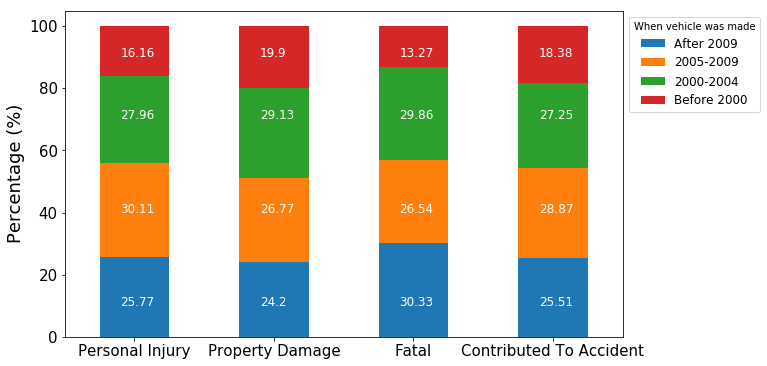

In [156]:
x_axis = ["Personal Injury", "Property Damage", "Fatal", "Contributed To Accident"]

index = pd.Index(x_axis)

data = {'After 2009': [25.77, 24.2, 30.33, 25.51],
        '2005-2009': [30.11, 26.77, 26.54, 28.87],
        '2000-2004': [27.96, 29.13, 29.86, 27.25],
        'Before 2000': [16.16, 19.9, 13.27, 18.38]
       }

plot_data = pd.DataFrame(data, index=index)
ax = plot_data.plot(kind='bar', stacked=True, figsize=(10, 6))
ax.set_ylabel('Percentage (%)', size=18)
ax.tick_params(axis='y', labelsize=15) 
ax.tick_params(axis='x', labelsize=15, rotation=0) 
plt.legend(title='When vehicle was made', bbox_to_anchor=(1.0, 1), loc='upper left', fontsize=12)

for idx, label in enumerate(list(index)): 
    for acc in plot_data.columns:
        value = plot_data.iloc[idx][acc]
        if acc == "After 2009":
            ax.annotate(value, (idx - 0.1, 10), color="white", fontsize=12)
        elif acc == "2005-2009":
            ax.annotate(value, (idx - 0.1, 40), color="white", fontsize=12)
        elif acc == "2000-2004":
            ax.annotate(value, (idx - 0.1, 70), color="white", fontsize=12)
        else:
            ax.annotate(value, (idx - 0.1, 90), color="white", fontsize=12)
plt.savefig("/mnt/bdpa21-group9-pvc/Figures/made_time_vs_seriousness.png")
plt.show()